# Tutorial for Cancer-Biomarkers-from-Clinical-Data

# 1. Data loading and preprocessing

## 1.1. Import the necessary modules

In [1]:
# Library imports
import numpy as np
import pandas as pd

# Add the path to the src folder
import sys
sys.path.append('src')

# Import the functions necessary for extracting the blood test data from the table by Cohen et al.
from extract_blood_test_table import extract_blood_test_table
from append_sheets_by_tumor_type import append_sheets_by_tumor_type

# Import project functions
from data_preprocessing import load_data, feature_label_split
from random_forest_model import rf_normal_cancers, plot_important_biomarkers
from desc_stats import descriptive_statistics, cancer_biomarkers_uniquely_high, cancer_biomarkers_higher_side_filtering
from stats_tests import find_shared_nature_of_biomarkers

## 1.2. Load the data

In [2]:
extract_blood_test_table()
append_sheets_by_tumor_type()

Table S6 extracted to data/prelim_clinical_cancer_data.xlsx
Data appended by tumor type to data/clinical_cancer_data.xlsx


In [3]:
categories, dfs = load_data('data/clinical_cancer_data.xlsx')

list(enumerate(categories))

[(0, 'Breast'),
 (1, 'Colorectum'),
 (2, 'Esophagus'),
 (3, 'Liver'),
 (4, 'Lung'),
 (5, 'Normal'),
 (6, 'Ovary'),
 (7, 'Pancreas'),
 (8, 'Stomach')]

In [4]:
biomarkers = feature_label_split(dfs[0])[0].columns
list(enumerate(biomarkers))

[(0, 'AFP'),
 (1, 'Angiopoietin-2'),
 (2, 'AXL'),
 (3, 'CA-125'),
 (4, 'CA 15-3'),
 (5, 'CA19-9'),
 (6, 'CD44'),
 (7, 'CEA'),
 (8, 'CYFRA 21-1'),
 (9, 'DKK1'),
 (10, 'Endoglin'),
 (11, 'FGF2'),
 (12, 'Follistatin'),
 (13, 'Galectin-3'),
 (14, 'G-CSF'),
 (15, 'GDF15'),
 (16, 'HE4'),
 (17, 'HGF'),
 (18, 'IL-6'),
 (19, 'IL-8'),
 (20, 'Kallikrein-6'),
 (21, 'Leptin'),
 (22, 'Mesothelin'),
 (23, 'Midkine'),
 (24, 'Myeloperoxidase'),
 (25, 'NSE'),
 (26, 'OPG'),
 (27, 'OPN'),
 (28, 'PAR'),
 (29, 'Prolactin'),
 (30, 'sEGFR'),
 (31, 'sFas'),
 (32, 'SHBG'),
 (33, 'sHER2/sEGFR2/sErbB2'),
 (34, 'sPECAM-1'),
 (35, 'TGFa'),
 (36, 'Thrombospondin-2'),
 (37, 'TIMP-1'),
 (38, 'TIMP-2')]

# 2. Analysis of `Ovary`, `Pancreas` and `Liver` samples, taken together with random subsamples of `Normal` samples

In this section, we will see three cancer types for which the list of biomarkers given by random forest classifier contain biomarkers with uniquely high level in the particular cancer type, along with other biomarkers whose Q3 values are in the top 2 among all cancer types. Essentially, in each of these cancer types, we obtain practically viable biomarkers. 

## 2.1. Analysis of `Normal + Ovary` samples

### 2.1.1. Random forest classification for `Normal + Ovary` samples

In [5]:
important_biomarkers_normal_ovary = rf_normal_cancers(categories = categories, 
                                                      dfs = dfs, 
                                                      cancer1_category_index = 6, 
                                                      iterations = 100,
                                                      threshold = 0.04,
                                                      save_feature_importances_list = True)

Random forest classification: Normal + Ovary

Average Accuracy over 100 iterations: 0.9695 ± 0.0397

Biomarkers with Importance >= 0.04:
    Biomarker  Importance
3      CA-125    0.158101
29  Prolactin    0.116618
18       IL-6    0.098022
35       TGFa    0.091397
31       sFas    0.067756
16        HE4    0.047304
37     TIMP-1    0.045132


And here's the list of the biomarker indices.

In [6]:
ovary_important_biomarker_indices_in_RF = list(important_biomarkers_normal_ovary.index)
ovary_important_biomarker_indices_in_RF

[3, 29, 18, 35, 31, 16, 37]

### 2.1.2. Filtering through descriptive statistics of biomarkers in `Normal + Ovary` samples

Now, we find that CA-125 is present in uniquely high levels in `Ovary` samples.

In [7]:
ovary_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories, 
                                                                 dfs = dfs, 
                                                                 cancer_important_biomarker_indices_in_RF = ovary_important_biomarker_indices_in_RF)


Biomarker 3: CA-125
Outlier categories with uniquely high Q2 levels: [('Ovary', 155.36)]
Outlier categories with uniquely high Q3 levels: [('Ovary', 486.2925)]


Let's see the biomarkers that pass through the uniquely high level criterion.

In [8]:
[biomarkers[i] for i in ovary_biomarkers_uniquely_high]

['CA-125']

And, `Prolactin` and `HE4` pass through the higher side filtering criteria.

In [9]:
ovary_candidates_for_higher_side_filtering = ovary_important_biomarker_indices_in_RF.copy()
ovary_candidates_for_higher_side_filtering.remove(ovary_biomarkers_uniquely_high[0])

ovary_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 6,
                                                                       cancer_candidates_for_higher_side_filtering = ovary_candidates_for_higher_side_filtering)


Biomarker 29: Prolactin
The biomarker's Q3 level is the highest in the given category.

Biomarker 16: HE4
The biomarker's Q3 level is the highest in the given category.


Here's the list of biomarkers that pass through the higher side filtering criteria.

In [10]:
[biomarkers[i] for i in ovary_biomarkers_higher_side]

['Prolactin', 'HE4']

Let's collect the biomarker indices that pass through the two descriptive statistics-based filtering criteria.


In [11]:
ovary_selected_biomarkers = ovary_biomarkers_uniquely_high + ovary_biomarkers_higher_side

[biomarkers[i] for i in ovary_selected_biomarkers]

['CA-125', 'Prolactin', 'HE4']

For example, let's see an overview of `CA-125` levels in all the cancer types, as well as the normal samples.

In [12]:
# descriptive_statistics(categories = categories, dfs = dfs, biomarker_index = 3)

### 2.1.3. Yuen-Welch's test of `CA-125`, `Prolactin` and `HE4` levels in `Ovary` samples versus all the other cancer types

In [13]:
ovary_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 6,
    cancer_selected_biomarkers = ovary_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 3: CA-125


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Pancreas,Stomach
Ovary,0.001463,0.001462,0.001475,0.001599,0.001514,0.001424,0.001808,0.001532



Biomarker 29: Prolactin


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Pancreas,Stomach
Ovary,0.000004,0.000027,6.358597e-07,0.004181,0.027951,4.928282e-08,0.000001,7.211565e-07



Biomarker 16: HE4 didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Pancreas,Stomach
Ovary,0.005554,0.010509,0.01596,0.007312,0.005743,0.005323,0.053539,0.005956


Now, we have the finalized list of biomarkers. Note that, `HE4` didn't pass the hypothesis test based criterion.

In [14]:
[(biomarkers[i], shared) for i, shared in ovary_shared_nature_of_biomarkers]

[('CA-125', []), ('Prolactin', []), ('HE4', ['Pancreas'])]

## 2.2. Analysis of `Normal + Pancreas` samples

### 2.2.1. Random forest classification for `Normal + Pancreas` samples

In [15]:
important_biomarkers_normal_pancreas = rf_normal_cancers(categories = categories, 
                                                         dfs = dfs, 
                                                         cancer1_category_index = 7, 
                                                         iterations = 100, 
                                                         threshold = 0.04,
                                                         save_feature_importances_list = True)

Random forest classification: Normal + Pancreas

Average Accuracy over 100 iterations: 0.9461 ± 0.0371

Biomarkers with Importance >= 0.04:
              Biomarker  Importance
5                CA19-9    0.142076
19                 IL-8    0.098437
18                 IL-6    0.078896
33  sHER2/sEGFR2/sErbB2    0.071969
27                  OPN    0.059424
15                GDF15    0.059301
23              Midkine    0.047857
17                  HGF    0.045496


In [16]:
pancreas_important_biomarker_indices_in_RF = list(important_biomarkers_normal_pancreas.index)
pancreas_important_biomarker_indices_in_RF

[5, 19, 18, 33, 27, 15, 23, 17]

### 2.2.2. Filtering through descriptive statistics of biomarkers in `Normal + Pancreas` samples

In [17]:
pancreas_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                    dfs = dfs,
                                                                    cancer_important_biomarker_indices_in_RF = pancreas_important_biomarker_indices_in_RF)


Biomarker 5: CA19-9
Outlier categories with uniquely high Q2 levels: [('Pancreas', 101.63)]
Outlier categories with uniquely high Q3 levels: [('Pancreas', 316.3)]


In [18]:
pancreas_biomarkers_uniquely_high

[5]

In [19]:
candidates_for_higher_side_filtering = pancreas_important_biomarker_indices_in_RF.copy()
candidates_for_higher_side_filtering.remove(pancreas_biomarkers_uniquely_high[0])

pancreas_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                          dfs = dfs,
                                                                          cancer_category_index = 7,
                                                                          cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)


Biomarker 19: IL-8
The biomarker's Q3 level is the third highest in the given category.

Biomarker 33: sHER2/sEGFR2/sErbB2
The biomarker's Q3 level is the highest in the given category.

Biomarker 15: GDF15
The biomarker's Q3 level is the highest in the given category.

Biomarker 23: Midkine
The biomarker's Q3 level is the highest in the given category.


In [20]:
pancreas_biomarkers_higher_side

[19, 33, 15, 23]

In [21]:
pancreas_selected_biomarkers = pancreas_biomarkers_uniquely_high + pancreas_biomarkers_higher_side

[biomarkers[i] for i in pancreas_selected_biomarkers]

['CA19-9', 'IL-8', 'sHER2/sEGFR2/sErbB2', 'GDF15', 'Midkine']

In [22]:
# descriptive_statistics(categories = categories, dfs = dfs, biomarker_index = 5)

### 2.2.3. Yuen-Welch's test of `CA19-9` and `SHER2/sEGFR2/sErbB2` levels in `Pancreas` samples versus all the other cancer types

In [23]:
pancreas_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 7,
    cancer_selected_biomarkers = pancreas_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 5: CA19-9


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Stomach
Pancreas,0.000004,0.000004,0.000006,0.000007,0.000004,0.000004,0.000028,0.000007



Biomarker 19: IL-8 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Stomach
Pancreas,5.606913e-07,0.003136,0.269314,0.755308,0.000024,1.059204e-08,0.000134,0.178375



Biomarker 33: sHER2/sEGFR2/sErbB2


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Stomach
Pancreas,2.149211e-14,5.880441e-15,1.794949e-18,1.036979e-14,2.269839e-16,NaN,4.954688e-17,4.144131e-19



Biomarker 15: GDF15 didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Stomach
Pancreas,2.203442e-11,0.000017,0.027547,0.404266,2.712515e-08,7.362665e-13,0.000408,0.0029



Biomarker 23: Midkine


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Stomach
Pancreas,7.493464e-10,0.000037,1.586982e-08,2.867214e-07,0.011287,NaN,0.000648,4.018868e-08


`IL-8` is immediately dropped. Because the p_values are greater than 0.05 for 3 comparisons.

In [24]:
[(biomarkers[i], shared) for i, shared in pancreas_shared_nature_of_biomarkers]

[('CA19-9', []),
 ('sHER2/sEGFR2/sErbB2', []),
 ('GDF15', ['Liver']),
 ('Midkine', [])]

## 2.3. Analysis of `Normal + Liver` samples

### 2.3.1. Random forest classification for `Normal + Liver` samples

In [25]:
important_biomarkers_normal_liver = rf_normal_cancers(categories = categories, 
                                                      dfs = dfs,
                                                      cancer1_category_index = 3,
                                                      iterations = 100,
                                                      threshold = 0.04,
                                                      save_feature_importances_list = True)

Random forest classification: Normal + Liver

Average Accuracy over 100 iterations: 0.9478 ± 0.0502

Biomarkers with Importance >= 0.04:
          Biomarker  Importance
19             IL-8    0.130324
17              HGF    0.124853
27              OPN    0.122065
15            GDF15    0.087213
24  Myeloperoxidase    0.059222
0               AFP    0.051895
18             IL-6    0.050542


In [26]:
liver_important_biomarker_indices_in_RF = list(important_biomarkers_normal_liver.index)
liver_important_biomarker_indices_in_RF

[19, 17, 27, 15, 24, 0, 18]

### 2.3.2. Filtering through descriptive statistics of biomarkers in `Normal + Liver` samples

In [27]:
liver_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = liver_important_biomarker_indices_in_RF)


Biomarker 0: AFP
Outlier categories with uniquely high Q2 levels: [('Liver', 9437.215)]
Outlier categories with uniquely high Q3 levels: [('Liver', 592839.507)]


In [28]:
candidates_for_higher_side_filtering = liver_important_biomarker_indices_in_RF.copy()
candidates_for_higher_side_filtering.remove(liver_biomarkers_uniquely_high[0])

liver_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 3,
                                                                       cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)


Biomarker 17: HGF
The biomarker's Q3 level is the second highest in the given category.

Biomarker 27: OPN
The biomarker's Q3 level is the highest in the given category.

Biomarker 15: GDF15
The biomarker's Q3 level is the second highest in the given category.

Biomarker 24: Myeloperoxidase
The biomarker's Q3 level is the highest in the given category.

Biomarker 18: IL-6
The biomarker's Q3 level is the second highest in the given category.


In [29]:
liver_selected_biomarkers = liver_biomarkers_uniquely_high + liver_biomarkers_higher_side

[biomarkers[i] for i in liver_selected_biomarkers]

['AFP', 'HGF', 'OPN', 'GDF15', 'Myeloperoxidase', 'IL-6']

In [30]:
# descriptive_statistics(categories = categories, dfs = dfs, biomarker_index = 0)

### 2.3.3 Yuen-Welch's test of `AFP`, `OPN`, `Myeloperoxidase`, `HGF` and `GDF15` levels in `Liver` samples versus all the other cancer types

In [31]:
liver_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 3,
    cancer_selected_biomarkers = liver_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 0: AFP


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,0.00179,0.001782,0.001816,0.001784,0.001772,0.001802,0.001904,0.001825



Biomarker 17: HGF didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,0.000034,0.000232,0.449572,0.000018,0.000009,0.000151,0.00141,0.669668



Biomarker 27: OPN didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,1.616969e-07,0.000039,0.126098,4.790950e-07,1.228216e-09,0.00003,0.000247,0.064973



Biomarker 15: GDF15 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,4.092896e-07,0.003002,0.217993,0.000041,4.776537e-08,0.015416,0.404266,0.05992



Biomarker 24: Myeloperoxidase didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,0.000201,0.000523,0.378072,0.00007,0.000049,0.000367,0.000153,0.280572



Biomarker 18: IL-6 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Lung,Normal,Ovary,Pancreas,Stomach
Liver,0.004487,0.027865,0.313319,0.222468,0.001131,0.044469,0.058245,0.050057


Note that `GDF15` and `IL-6` are dropped.

In [32]:
liver_shared_nature_of_biomarkers

[(0, []),
 (17, ['Esophagus', 'Stomach']),
 (27, ['Esophagus', 'Stomach']),
 (24, ['Esophagus', 'Stomach'])]

## 2.4. RandomForest accuracy scores for classifying liver, ovarian, and pancreatic cancers from normal ones  

In this section, we use a switch `roc = True` for generating the ROC curves with AUC scores. This switch also makes sure that the train-test split is stratified. Hence, we will see that the classification accuracy changes a little bit from the previous one. We report the present classification accuracy in the article.

### 2.4.1. Normal + Liver with `AFP`, `OPN`, `Myeloperoxidase` and `HGF`

Random forest classification: Normal + Liver

Average Accuracy over 100 iterations: 0.9075 ± 0.0446

Biomarkers with Importance >= 0.01:
         Biomarker  Importance
1              HGF    0.376439
2              OPN    0.344609
0              AFP    0.140436
3  Myeloperoxidase    0.138516
Model classes: ['Liver' 'Normal']


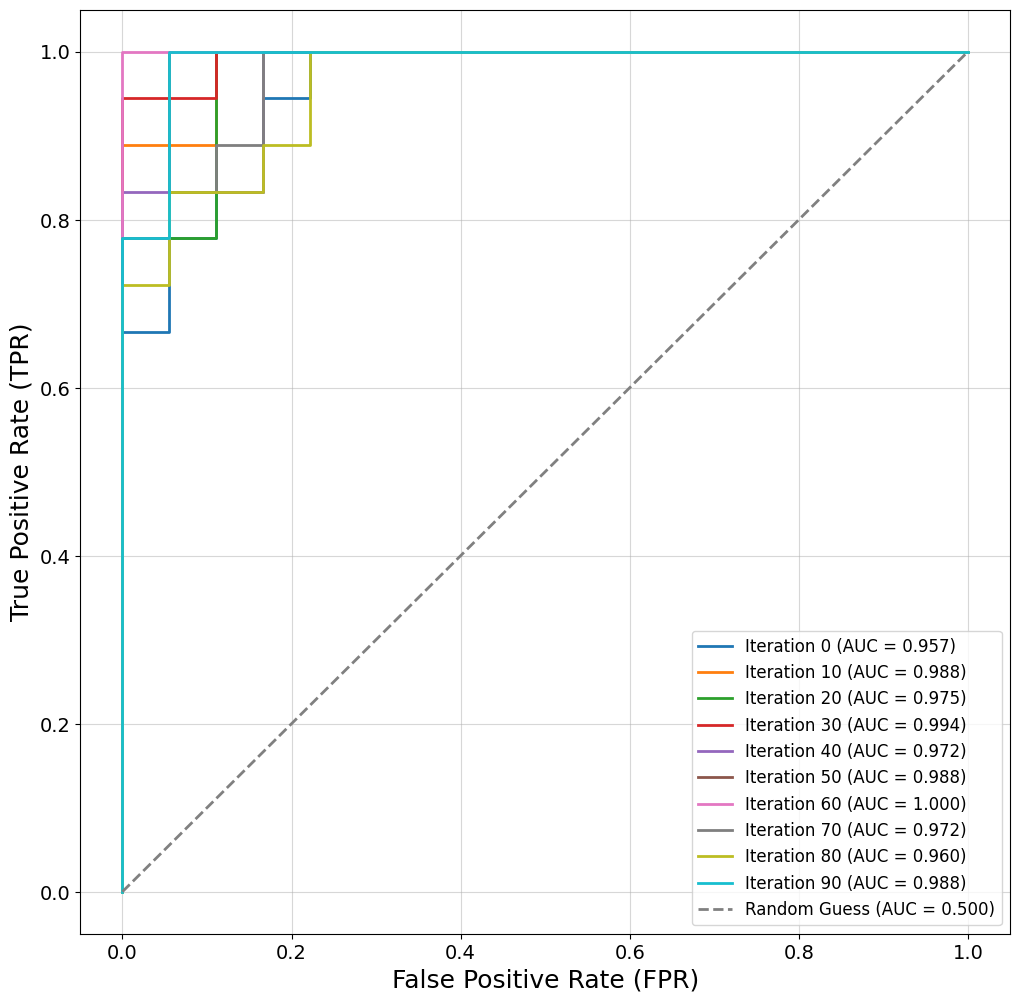

,Biomarker,Importance
1,HGF,0.376439
2,OPN,0.344609
0,AFP,0.140436
3,Myeloperoxidase,0.138516


In [33]:
liver_finalized_biomarkers = [i for i, _ in liver_shared_nature_of_biomarkers]
rf_normal_cancers(categories = categories, 
                  dfs = dfs,
                  cancer1_category_index = 3,
                  selected_biomarkers = np.array(liver_finalized_biomarkers),
                  test_size = 0.4,
                  iterations = 100,
                  threshold = 0.01,
                  debug = True,
                  roc = True)

### 2.4.2. Normal + Ovary with `CA-125`, `Prolactin` and `HE4`

Random forest classification: Normal + Ovary

Average Accuracy over 100 iterations: 0.9605 ± 0.0303

Biomarkers with Importance >= 0.01:
   Biomarker  Importance
0     CA-125    0.399024
1  Prolactin    0.345601
2        HE4    0.255375
Model classes: ['Normal' 'Ovary']


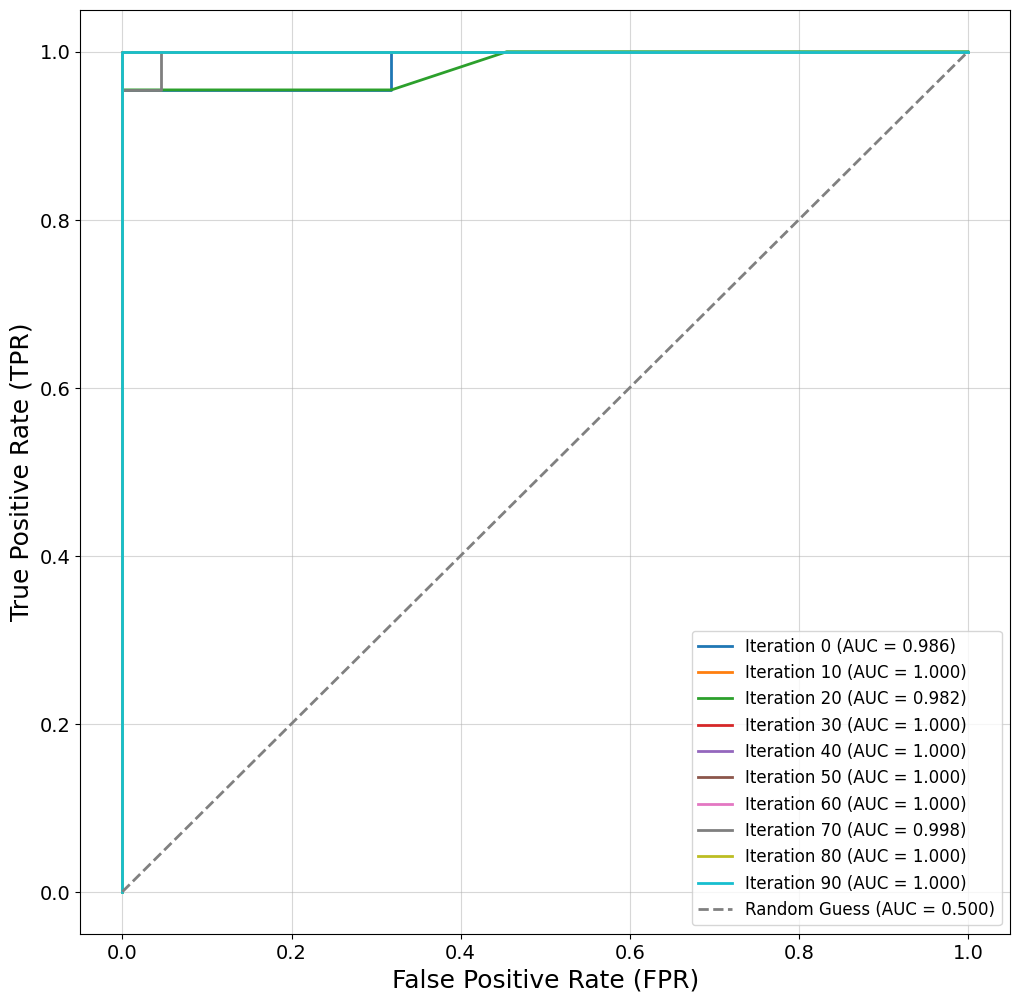

,Biomarker,Importance
0,CA-125,0.399024
1,Prolactin,0.345601
2,HE4,0.255375


In [34]:
ovary_finalized_biomarkers = [i for i, _ in ovary_shared_nature_of_biomarkers]
rf_normal_cancers(categories = categories, 
                  dfs = dfs,
                  cancer1_category_index = 6,
                  selected_biomarkers = np.array(ovary_finalized_biomarkers),
                  test_size = 0.4,
                  iterations = 100,
                  threshold = 0.01,
                  debug = True,
                  roc = True)

### 2.4.3. Normal + Pancreas with `CA19-9`, `sHER2/sEGFR2/sErbB2`, `Midkine` and `GDF15`

Random forest classification: Normal + Pancreas

Average Accuracy over 100 iterations: 0.9073 ± 0.0304

Biomarkers with Importance >= 0.05:
             Biomarker  Importance
0               CA19-9    0.430301
1  sHER2/sEGFR2/sErbB2    0.232550
2                GDF15    0.193126
3              Midkine    0.144023
Model classes: ['Normal' 'Pancreas']


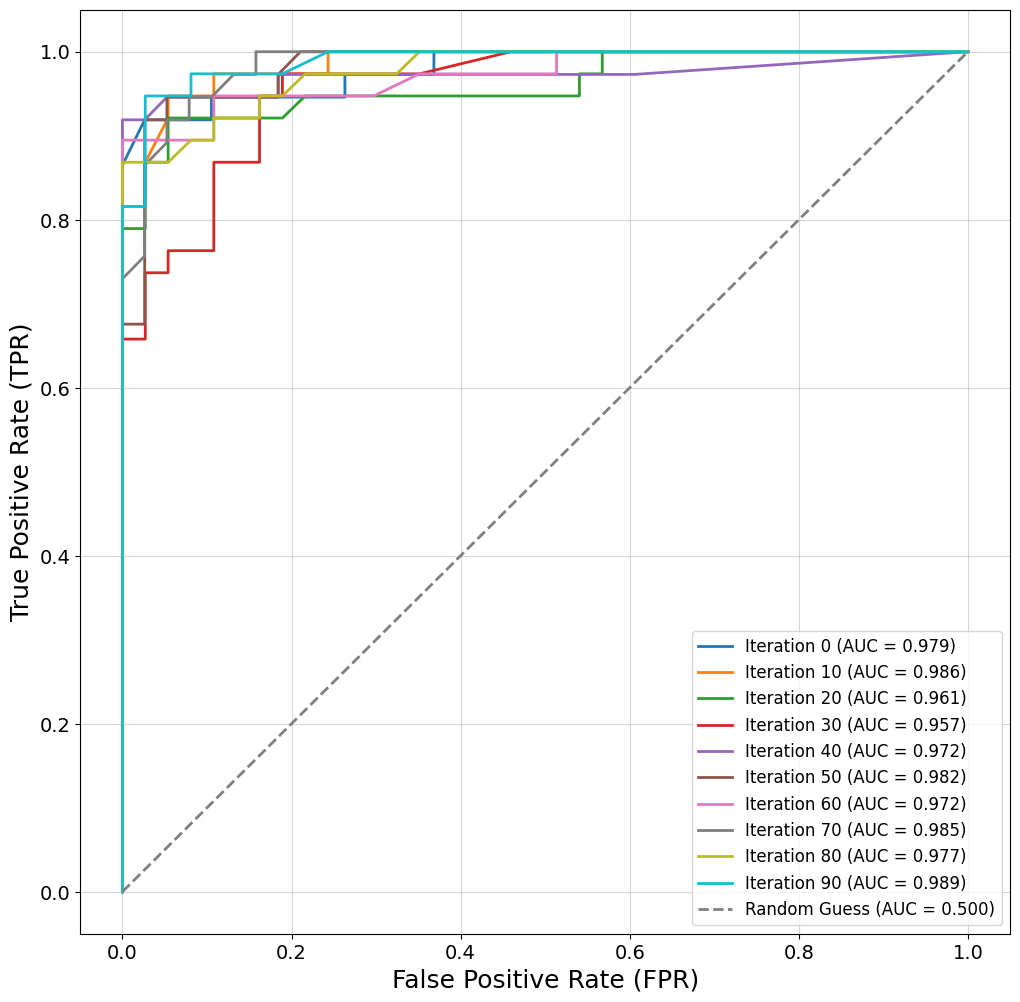

,Biomarker,Importance
0,CA19-9,0.430301
1,sHER2/sEGFR2/sErbB2,0.232550
2,GDF15,0.193126
3,Midkine,0.144023


In [35]:
pancreas_finalized_biomarkers = [i for i, _ in pancreas_shared_nature_of_biomarkers]
rf_normal_cancers(categories = categories, 
                  dfs = dfs,
                  cancer1_category_index = 7,
                  selected_biomarkers = np.array(pancreas_finalized_biomarkers),
                  test_size = 0.4,
                  iterations = 100,
                  threshold = 0.05,
                  debug = True,
                  roc = True)

### 2.4.4. Normal + Liver + Ovary + Pancreas

In [36]:
liver_ovary_pancreas_finalized_biomarkers = liver_finalized_biomarkers + ovary_finalized_biomarkers + pancreas_finalized_biomarkers
rf_normal_cancers(categories = categories, 
                  dfs = dfs,
                  cancer1_category_index = 3,
                  cancer2_category_index = 6,
                  cancer3_category_index = 7,
                  selected_biomarkers = np.array(liver_ovary_pancreas_finalized_biomarkers),
                  test_size = 0.4,
                  iterations = 100,
                  threshold = 0.05)

Random forest classification: Normal + Liver + Ovary + Pancreas

Average Accuracy over 100 iterations: 0.8393 ± 0.0441

Biomarkers with Importance >= 0.05:
              Biomarker  Importance
4                CA-125    0.143234
8   sHER2/sEGFR2/sErbB2    0.128073
2                   OPN    0.095641
7                CA19-9    0.095429
0                   AFP    0.091084
1                   HGF    0.090679
9                 GDF15    0.085300
5             Prolactin    0.081569
3       Myeloperoxidase    0.069521
6                   HE4    0.067606
10              Midkine    0.051864


,Biomarker,Importance
4,CA-125,0.143234
8,sHER2/sEGFR2/sErbB2,0.128073
2,OPN,0.095641
7,CA19-9,0.095429
0,AFP,0.091084
1,HGF,0.090679
9,GDF15,0.085300
5,Prolactin,0.081569
3,Myeloperoxidase,0.069521
6,HE4,0.067606


# 3. Analysis of `Breast` and `Colorectum` samples, taken together with random subsamples of `Normal` samples

Now we see two cancer types for which the important biomarkers given by random forest classifier are not suitable in practical scenario for distinguishing between different cancer types from normal samples. None of the biomarkers display uniquely high level for the particular cancer type, and none can be found with Q3 level in top 2 among all the cancer types. 

## 3.1. Analysis of `Normal + Breast` samples

### 3.1.1. Random forest classification for `Normal + Breast` samples

In [37]:
important_biomarkers_normal_breast = rf_normal_cancers(categories = categories, 
                                                       dfs = dfs,
                                                       cancer1_category_index = 0,
                                                       iterations = 100,
                                                       threshold = 0.04,
                                                       save_feature_importances_list = True)

Random forest classification: Normal + Breast

Average Accuracy over 100 iterations: 0.9674 ± 0.0216

Biomarkers with Importance >= 0.04:
     Biomarker  Importance
35        TGFa    0.104872
19        IL-8    0.088202
18        IL-6    0.083037
29   Prolactin    0.054947
8   CYFRA 21-1    0.049681
27         OPN    0.048677
16         HE4    0.046551
30       sEGFR    0.044637


And here's list of biomarkers that were selected by random forest classifier for `Normal + Breast` samples.

In [38]:
breast_important_biomarker_indices_in_RF = list(important_biomarkers_normal_breast.index)
breast_important_biomarker_indices_in_RF

[35, 19, 18, 29, 8, 27, 16, 30]

### 3.1.2. Filtering through descriptive statistics of biomarkers in `Normal + Breast` samples

Now, we see that none of the biomarkers selected by Random Forest is present in uniquely high levels in the `Breast` samples.

In [39]:
breast_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = breast_important_biomarker_indices_in_RF)

And none satisfy the higher side filtering criterion.

In [40]:
candidates_for_higher_side_filtering = breast_important_biomarker_indices_in_RF.copy()
if len(breast_biomarkers_uniquely_high) != 0:
    candidates_for_higher_side_filtering.remove(breast_biomarkers_uniquely_high[0])

breast_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 0,
                                                                       cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)

So, we've got no biomarker left at the end of the filtering process.

## 3.2. Analysis of `Normal + Colorectum` samples

### 3.2.1. Random forest classification for `Normal + Colorectum` samples

In [41]:
important_biomarkers_normal_colorectum = rf_normal_cancers(categories = categories, 
                                                           dfs = dfs,
                                                           cancer1_category_index = 1,
                                                           iterations = 100,
                                                           threshold = 0.04,
                                                           save_feature_importances_list = True)

Random forest classification: Normal + Colorectum

Average Accuracy over 100 iterations: 0.9591 ± 0.0164

Biomarkers with Importance >= 0.04:
    Biomarker  Importance
19       IL-8    0.140534
27        OPN    0.094979
18       IL-6    0.094810
17        HGF    0.062834
15      GDF15    0.058310
31       sFas    0.054001
29  Prolactin    0.052902


In [42]:
colorectum_important_biomarker_indices_in_RF = list(important_biomarkers_normal_colorectum.index)
colorectum_important_biomarker_indices_in_RF

[19, 27, 18, 17, 15, 31, 29]

### 3.2.2. Filtering through descriptive statistics of biomarkers in `Normal + Colorectum` samples

* Uniquely high levels: None
* Higher side filtering: None

Note that, `IL-8` and `IL-6`, being important in regulating immune response and inflammation, are not specific to any one type of cancer. For example, the same two biomarkers are two of the most important ones in separating `Normal` and `Breast` samples, as shown above. And they can be found in higher levels in some other cancer types, such as `Esophagus`, `Liver` and `Lung` samples.

`OPN` Q3 levels are much higher in `Esophagus`, `Liver`, and `Stomach` samples than in `Colorectum` samples.

`HGF` Q3 levels are higher in `Pancreas` samples, and much higher in `Esophagus`, `Liver`, and `Stomach` samples than in `Colorectum` samples.

`GDF15` Q3 levels are close in `Colorectum` and Ovary samples, and higher in `Esophagus`, `Liver`, `Stomach` and `Pancreas` samples than in `Colorectum` samples.

`sFas` Q3 levels are higher in `Breast`, `Esophagus`, `Liver`, `Lung`, `Pancreas`, `Stomach` and even `Normal` samples than in `Colorectum` samples.

`Prolactin` levels are much higher in `Liver`, `Lung` and `Ovary` samples than in `Colorectum` samples.



In [43]:
colorectum_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = colorectum_important_biomarker_indices_in_RF)

In [44]:
candidates_for_higher_side_filtering = colorectum_important_biomarker_indices_in_RF.copy()
if len(colorectum_biomarkers_uniquely_high) != 0:
    candidates_for_higher_side_filtering.remove(colorectum_biomarkers_uniquely_high[0])

colorectum_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                            dfs = dfs,
                                                                            cancer_category_index = 1,
                                                                            cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)

# 4. Analysis of `Esophagus`, `Lung` and `Stomach` samples, taken together with random subsamples of `Normal` samples

## 4.1. Analysis of `Normal + Esophagus` samples

### 4.1.1. Random forest classification for `Normal + Esophagus` samples

In [45]:
important_biomarkers_normal_esophagus = rf_normal_cancers(categories = categories, 
                                                          dfs = dfs,
                                                          cancer1_category_index = 2,
                                                          iterations = 100,
                                                          threshold = 0.04,
                                                          save_feature_importances_list = True)

Random forest classification: Normal + Esophagus

Average Accuracy over 100 iterations: 0.8694 ± 0.0730

Biomarkers with Importance >= 0.04:
          Biomarker  Importance
27              OPN    0.102094
17              HGF    0.097354
18             IL-6    0.078464
19             IL-8    0.071014
15            GDF15    0.062430
24  Myeloperoxidase    0.054283
37           TIMP-1    0.052317
30            sEGFR    0.042101


In [46]:
esophagus_important_biomarker_indices_in_RF = list(important_biomarkers_normal_esophagus.index)
esophagus_important_biomarker_indices_in_RF

[27, 17, 18, 19, 15, 24, 37, 30]

### 4.1.2.  Filtering through descriptive statistics of biomarkers in `Normal + Esophagus` samples

In [47]:
esophagus_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = esophagus_important_biomarker_indices_in_RF)

In [48]:
candidates_for_higher_side_filtering = esophagus_important_biomarker_indices_in_RF.copy()
if len(esophagus_biomarkers_uniquely_high) != 0:
    candidates_for_higher_side_filtering.remove(esophagus_biomarkers_uniquely_high[0])

esophagus_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 2,
                                                                       cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)


Biomarker 27: OPN
The biomarker's Q3 level is the second highest in the given category.

Biomarker 17: HGF
The biomarker's Q3 level is the third highest in the given category.

Biomarker 18: IL-6
The biomarker's Q3 level is the highest in the given category.

Biomarker 19: IL-8
The biomarker's Q3 level is the second highest in the given category.

Biomarker 15: GDF15
The biomarker's Q3 level is the third highest in the given category.

Biomarker 24: Myeloperoxidase
The biomarker's Q3 level is the second highest in the given category.

Biomarker 37: TIMP-1
The biomarker's Q3 level is the highest in the given category.


In [49]:
esophagus_selected_biomarkers = esophagus_biomarkers_uniquely_high + esophagus_biomarkers_higher_side

[biomarkers[i] for i in esophagus_selected_biomarkers]

['OPN', 'HGF', 'IL-6', 'IL-8', 'GDF15', 'Myeloperoxidase', 'TIMP-1']

### 4.1.3. Yuen-Welch's test of filtered biomarkers' levels in `Esophagus` samples versus all the other cancer types

In [50]:
esophagus_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 2,
    cancer_selected_biomarkers = esophagus_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 27: OPN didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000004,0.002575,0.126098,0.000016,8.228244e-09,0.002064,0.016719,0.859041



Biomarker 17: HGF didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000012,0.000163,0.449572,0.000005,0.000002,0.000096,0.001961,0.752577



Biomarker 18: IL-6 didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000055,0.00053,0.313319,0.012079,0.000011,0.001099,0.001523,0.001212



Biomarker 19: IL-8 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000087,0.004294,0.396322,0.000398,0.000018,0.000807,0.269314,0.780826



Biomarker 15: GDF15 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000001,0.049825,0.217993,0.000415,7.205010e-08,0.18321,0.027547,0.507677



Biomarker 24: Myeloperoxidase didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.003697,0.009131,0.378072,0.001306,0.000913,0.006547,0.00283,0.881598



Biomarker 37: TIMP-1 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Liver,Lung,Normal,Ovary,Pancreas,Stomach
Esophagus,0.000001,0.000211,0.1256,0.000007,9.526355e-07,0.164092,0.169581,0.03306


In [51]:
esophagus_shared_nature_of_biomarkers

[(27, ['Liver', 'Stomach']),
 (17, ['Liver', 'Stomach']),
 (18, ['Liver']),
 (24, ['Liver', 'Stomach'])]

In [52]:
[(biomarkers[i], shared) for i, shared in esophagus_shared_nature_of_biomarkers]

[('OPN', ['Liver', 'Stomach']),
 ('HGF', ['Liver', 'Stomach']),
 ('IL-6', ['Liver']),
 ('Myeloperoxidase', ['Liver', 'Stomach'])]

## 4.2. Analysis of `Normal + Lung` samples

### 4.2.1. Random forest classification for `Normal + Lung` samples

In [53]:
important_biomarkers_normal_lung = rf_normal_cancers(categories = categories, 
                                                     dfs = dfs,
                                                     cancer1_category_index = 4,
                                                     iterations = 100,
                                                     threshold = 0.04,
                                                     save_feature_importances_list = True)

Random forest classification: Normal + Lung

Average Accuracy over 100 iterations: 0.9755 ± 0.0246

Biomarkers with Importance >= 0.04:
     Biomarker  Importance
29   Prolactin    0.154649
25         NSE    0.080318
19        IL-8    0.080229
18        IL-6    0.074883
15       GDF15    0.055032
27         OPN    0.053836
8   CYFRA 21-1    0.048110


In [54]:
lung_important_biomarker_indices_in_RF = list(important_biomarkers_normal_lung.index)
lung_important_biomarker_indices_in_RF

[29, 25, 19, 18, 15, 27, 8]

### 4.2.2. Filtering through descriptive statistics of biomarkers in `Normal + Lung` samples

In [55]:
lung_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = lung_important_biomarker_indices_in_RF)

In [56]:
candidates_for_higher_side_filtering = lung_important_biomarker_indices_in_RF.copy()
if len(lung_biomarkers_uniquely_high) != 0:
    candidates_for_higher_side_filtering.remove(lung_biomarkers_uniquely_high[0])

lung_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 4,
                                                                       cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)


Biomarker 29: Prolactin
The biomarker's Q3 level is the second highest in the given category.

Biomarker 18: IL-6
The biomarker's Q3 level is the third highest in the given category.

Biomarker 8: CYFRA 21-1
The biomarker's Q3 level is the highest in the given category.


In [57]:
lung_selected_biomarkers = lung_biomarkers_uniquely_high + lung_biomarkers_higher_side

[biomarkers[i] for i in lung_selected_biomarkers]

['Prolactin', 'IL-6', 'CYFRA 21-1']

### 4.2.3. Yuen-Welch's test of filtered biomarkers' levels in `Lung` samples versus all the other cancer types

In [58]:
lung_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 4,
    cancer_selected_biomarkers = lung_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 29: Prolactin didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Normal,Ovary,Pancreas,Stomach
Lung,9.719895e-08,0.000016,3.830400e-09,0.155303,5.188405e-14,0.027951,1.719043e-08,6.396915e-10



Biomarker 18: IL-6 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Liver,Normal,Ovary,Pancreas,Stomach
Lung,0.000145,0.024907,0.012079,0.222468,5.527829e-07,0.113291,0.168486,0.121762



Biomarker 8: CYFRA 21-1 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Liver,Normal,Ovary,Pancreas,Stomach
Lung,0.004622,0.001949,0.58737,0.553203,5.751209e-07,0.183812,0.066042,0.024372


In [59]:
[(biomarkers[i], shared) for i, shared in lung_shared_nature_of_biomarkers]

[('Prolactin', ['Liver'])]

## 4.3. Analysis of `Normal + Stomach` samples

### 4.3.1. Random forest classification for `Normal + Stomach` samples

In [60]:
important_biomarkers_normal_stomach = rf_normal_cancers(categories = categories, 
                                                        dfs = dfs,
                                                        cancer1_category_index = 8,
                                                        iterations = 100,
                                                        threshold = 0.04,
                                                        save_feature_importances_list = True)

Random forest classification: Normal + Stomach

Average Accuracy over 100 iterations: 0.9307 ± 0.0571

Biomarkers with Importance >= 0.04:
          Biomarker  Importance
27              OPN    0.150878
19             IL-8    0.094648
18             IL-6    0.083897
15            GDF15    0.070913
17              HGF    0.060877
30            sEGFR    0.054287
24  Myeloperoxidase    0.043201
8        CYFRA 21-1    0.041684


In [61]:
stomach_important_biomarker_indices_in_RF = list(important_biomarkers_normal_stomach.index)
stomach_important_biomarker_indices_in_RF

[27, 19, 18, 15, 17, 30, 24, 8]

### 4.3.2. Filtering through descriptive statistics of biomarkers in `Normal + Stomach` samples

In [62]:
stomach_biomarkers_uniquely_high = cancer_biomarkers_uniquely_high(categories = categories,
                                                                 dfs = dfs,
                                                                 cancer_important_biomarker_indices_in_RF = stomach_important_biomarker_indices_in_RF)

In [63]:
candidates_for_higher_side_filtering = stomach_important_biomarker_indices_in_RF.copy()
if len(stomach_biomarkers_uniquely_high) != 0:
    candidates_for_higher_side_filtering.remove(stomach_biomarkers_uniquely_high[0])

stomach_biomarkers_higher_side = cancer_biomarkers_higher_side_filtering(categories = categories,
                                                                       dfs = dfs,
                                                                       cancer_category_index = 8,
                                                                       cancer_candidates_for_higher_side_filtering = candidates_for_higher_side_filtering)


Biomarker 27: OPN
The biomarker's Q3 level is the third highest in the given category.

Biomarker 19: IL-8
The biomarker's Q3 level is the highest in the given category.

Biomarker 17: HGF
The biomarker's Q3 level is the highest in the given category.

Biomarker 24: Myeloperoxidase
The biomarker's Q3 level is the third highest in the given category.


In [64]:
stomach_selected_biomarkers = stomach_biomarkers_uniquely_high + stomach_biomarkers_higher_side

[biomarkers[i] for i in stomach_selected_biomarkers]

['OPN', 'IL-8', 'HGF', 'Myeloperoxidase']

### 4.3.3. Yuen-Welch's test of filtered biomarkers' levels in `Stomach` samples versus all the other cancer types

In [65]:
stomach_shared_nature_of_biomarkers = find_shared_nature_of_biomarkers(
    categories = categories,
    dfs = dfs,
    cancer_category_index = 8,
    cancer_selected_biomarkers = stomach_selected_biomarkers,
    p_threshold = 0.05,
    debug = True
)


Biomarker 27: OPN didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Pancreas
Stomach,2.381258e-09,0.000138,0.859041,0.064973,2.695172e-08,5.476364e-14,0.000211,0.00496



Biomarker 19: IL-8 didn't pass the p-value cutoff for three or more categories. It is dropped.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Pancreas
Stomach,0.000063,0.003014,0.780826,0.268987,0.000292,0.000012,0.000589,0.178375



Biomarker 17: HGF didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Pancreas
Stomach,0.000026,0.000282,0.752577,0.669668,0.000011,0.000004,0.000175,0.002486



Biomarker 24: Myeloperoxidase didn't pass the p-value cutoff for one or two categories.


,Breast,Colorectum,Esophagus,Liver,Lung,Normal,Ovary,Pancreas
Stomach,0.00154,0.004911,0.881598,0.280572,0.000393,0.000245,0.003247,0.001087


In [66]:
stomach_shared_nature_of_biomarkers

[(27, ['Esophagus', 'Liver']),
 (17, ['Esophagus', 'Liver']),
 (24, ['Esophagus', 'Liver'])]

In [67]:
[biomarkers[i] for i, _ in stomach_shared_nature_of_biomarkers]

['OPN', 'HGF', 'Myeloperoxidase']

# 5. Summary of findings

Now, let's have a look at all the cancer types and their selected biomarkers, with shared nature. We make a few summarizing comments, looking at all the cancer types and their selected biomarkers, with shared nature.

## 5.1. `Ovary` biomarkers 
We make a comment that `HE4` might be shared with `Pancreas`.

In [68]:
[(biomarkers[i],  shared) for i, shared in ovary_shared_nature_of_biomarkers]

[('CA-125', []), ('Prolactin', []), ('HE4', ['Pancreas'])]

## 5.2. `Pancreas` biomarkers 
We make a comment that `GDF15` might be shared with `Liver`.

In [69]:
[(biomarkers[i], shared) for i, shared in pancreas_shared_nature_of_biomarkers]

[('CA19-9', []),
 ('sHER2/sEGFR2/sErbB2', []),
 ('GDF15', ['Liver']),
 ('Midkine', [])]

## 5.3. `Liver` biomarkers
Note that `HGF`, `OPN` and `Myloperoxidase` are hereby confirmed as shared between `Liver`, `Esophagus` and `Stomach`.

In [70]:
[(biomarkers[i], shared) for i, shared in liver_shared_nature_of_biomarkers]

[('AFP', []),
 ('HGF', ['Esophagus', 'Stomach']),
 ('OPN', ['Esophagus', 'Stomach']),
 ('Myeloperoxidase', ['Esophagus', 'Stomach'])]

## 5.4. `Esophagus` biomarkers
Note the sharing of `OPN`, `HGF` and `Myloperoxidase` with `Liver` and `Stomach`.

In [71]:
[(biomarkers[i], shared) for i, shared in esophagus_shared_nature_of_biomarkers]

[('OPN', ['Liver', 'Stomach']),
 ('HGF', ['Liver', 'Stomach']),
 ('IL-6', ['Liver']),
 ('Myeloperoxidase', ['Liver', 'Stomach'])]

## 5.5. `Stomach` biomarkers
Note the sharing of `OPN`, `HGF` and `Myloperoxidase` with `Liver` and `Esophagus`.

In [72]:
[(biomarkers[i], shared) for i, shared in stomach_shared_nature_of_biomarkers]

[('OPN', ['Esophagus', 'Liver']),
 ('HGF', ['Esophagus', 'Liver']),
 ('Myeloperoxidase', ['Esophagus', 'Liver'])]

## 5.6. `Lung` biomarkers
Since `Prolactin` is reported in the higher side filtering of `Ovary` with no shared nature, and it's levels are the highest in `Ovary`, we do not consider it a reliable biomarker for `Lung` cancer.

In [73]:
[(biomarkers[i], shared) for i, shared in lung_shared_nature_of_biomarkers]

[('Prolactin', ['Liver'])]

## 6. Conclusions

In [74]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

### 6.1. Important Biomarkers Chosen at First Step

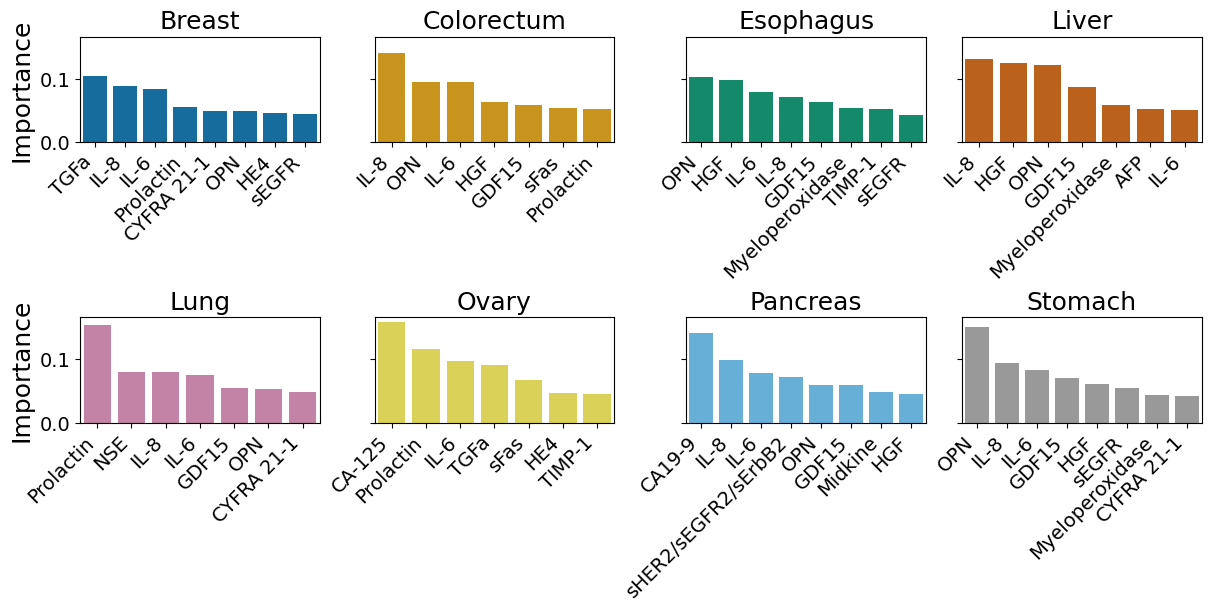

In [75]:
# Color-blind friendly palette
cbf_colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9', '#999999']
importance_scores = [important_biomarkers_normal_breast, important_biomarkers_normal_colorectum, important_biomarkers_normal_esophagus, important_biomarkers_normal_liver, important_biomarkers_normal_lung, important_biomarkers_normal_ovary, important_biomarkers_normal_pancreas, important_biomarkers_normal_stomach]

fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True, constrained_layout=True)
axs.flatten()
for i, ax in enumerate(axs.flatten()):
    sns.barplot(data=importance_scores[i], x="Biomarker", y="Importance", ax=ax, color=cbf_colors[i])
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_xlabel('')
    ax.set_ylabel('Importance', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    if i<5:
        # ax.set_title(f'Normal + {categories[i]}')
        ax.set_title(f'{categories[i]}', fontsize=18)
    else:
        # ax.set_title(f'Normal + {categories[i+1]}')
        ax.set_title(f'{categories[i+1]}', fontsize=18)

# fig.suptitle(f"Important biomarkers in Random Forest classification based on MDI scores (cutoff 0.04)\n", fontsize=14)

fig.savefig("FIG2.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### 6.2. Descriptive statistics based filtering

#### 6.2.1. Uniquely high levels

In [76]:
data_rows = []
rf_important_biomarkers = pd.concat(importance_scores, axis=0, ignore_index=True).iloc[:, 0].unique()
for biomarker in rf_important_biomarkers:
    for i, cancer_type in enumerate(categories):
        df = dfs[i]
        desc_stats = df[biomarker].describe()
        mean = desc_stats['mean']
        std = desc_stats['std']
        cv = mean / std
        Q2 = desc_stats['50%']
        Q3 = desc_stats['75%']
        data_row_Q2 = [biomarker, Q2, 'Q2', cancer_type]
        data_row_Q3 = [biomarker, Q3, 'Q3', cancer_type]
        data_rows.append(data_row_Q2)
        data_rows.append(data_row_Q3)
        
columns = ['Biomarker', 'Level', 'Quartile', 'Tumor_type']
cv_boxplot_df = pd.DataFrame(data_rows, columns=columns).replace('sHER2/sEGFR2/sErbB2', 'sHER2').replace('CA-125', 'CA-125 ★').replace('CA19-9', 'CA19-9 ★').replace('AFP', 'AFP ★')

# facet_kws = dict(col_wrap=3)
# sns.catplot(data=cv_boxplot_df, x='Quartile', y='Level', hue='Tumor_type', col='Biomarker', aspect=0.5, col_wrap=3)

biomarkers_0_to_200000_range = ['Prolactin', 'OPN', 'Myeloperoxidase', 'NSE', 'TIMP-1']
biomarkers_0_to_10000_range = ['CYFRA 21-1', 'HE4', 'sEGFR', 'HGF', 'GDF15', 'sFas', 'sHER2', 'Midkine']
biomarkers_TGFa = ['TGFa']
biomarkers_0_to_200_range = ['IL-8', 'IL-6']
biomarkers_AFP = ['AFP ★']
biomarker_sets_together = biomarkers_0_to_200000_range + biomarkers_0_to_10000_range + biomarkers_TGFa + biomarkers_0_to_200_range + biomarkers_AFP
cv_boxplot_df_1 = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(biomarkers_0_to_200000_range)]
cv_boxplot_df_2 = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(biomarkers_0_to_10000_range)]
cv_boxplot_df_TGFa = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(biomarkers_TGFa)]
cv_boxplot_df_added = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(biomarkers_0_to_200_range)]
cv_boxplot_df_3 = cv_boxplot_df[~cv_boxplot_df['Biomarker'].isin(biomarker_sets_together)]
cv_boxplot_df_4 = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(biomarkers_AFP)]

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_25732\1099833376.py:141: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig("FIG3.pDF", dpi=600, bbox_inches='tight', format='pdf')
c:\Users\SAMSUNG\Desktop\Github\Cancer-Biomarkers-from-Clinical-Data\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


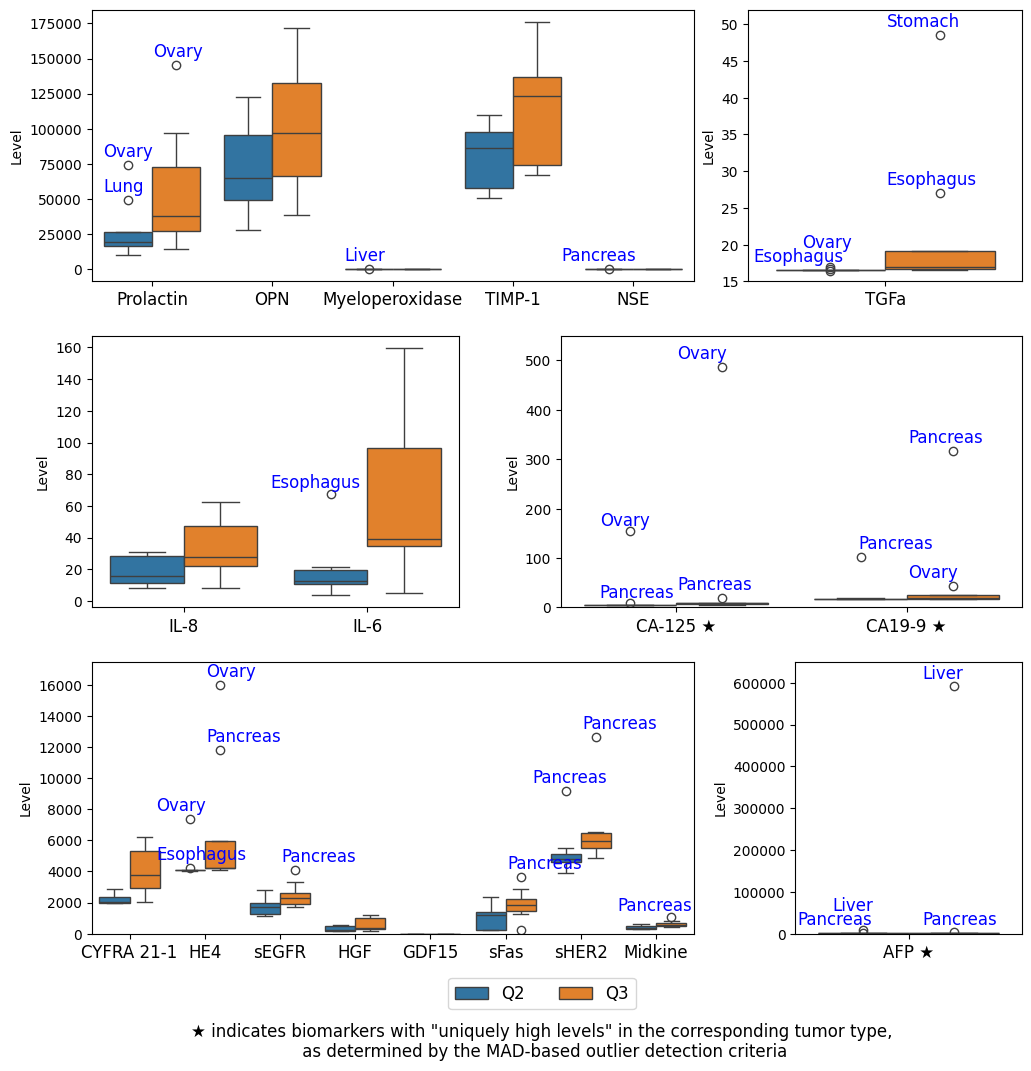

In [77]:
boxplot_dfs = [cv_boxplot_df_1, cv_boxplot_df_TGFa, cv_boxplot_df_added, cv_boxplot_df_3, cv_boxplot_df_2, cv_boxplot_df_4]

# Create figure with flexible layout
fig = plt.figure(figsize=(12, 12), constrained_layout = True)
gs = GridSpec(3, 20, figure=fig)
text_font_size = 12

# Define subplots (6:4 width ratio for the first row, 8:2 width ratio for the second row)
ax1 = fig.add_subplot(gs[0, :13])  # First row, first subplot (occupying 6 columns)
ax2 = fig.add_subplot(gs[0, 14:])
ax3 = fig.add_subplot(gs[1, :8])
ax4 = fig.add_subplot(gs[1, 10:])  # First row, second subplot (occupying 4 columns)
ax5 = fig.add_subplot(gs[2, :13])  # Second row, first subplot (occupying 8 columns)
ax6 = fig.add_subplot(gs[2, 15:])  # Second row, second subplot (occupying 2 columns)

ax2.set_ylim(bottom=15, top=52)
ax4.set_ylim(top=550)
ax5.set_ylim(top=17500)
ax6.set_ylim(top=650000)

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, ax in enumerate(axs):
    # sns.stripplot(data=boxplot_dfs[i], x = 'Biomarker', y = 'Level',  hue = 'Quartile', dodge=True, jitter=False, ax=ax)
    sns.boxplot(data=boxplot_dfs[i], x = 'Biomarker', y = 'Level',  hue = 'Quartile', ax=ax)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=12)
    # ax.spines['top'].set_visible(False)
    # Add outlier annotations
    for biomarker in boxplot_dfs[i]['Biomarker'].unique():
        biomarker_data = boxplot_dfs[i][boxplot_dfs[i]['Biomarker'] == biomarker]
        
        for quartile in biomarker_data['Quartile'].unique():
            data = biomarker_data[biomarker_data['Quartile'] == quartile]
            levels = data['Level']
            tumor_types = data['Tumor_type']
            
            q1 = levels.quantile(0.25)
            q3 = levels.quantile(0.75)
            iqr = q3 - q1
            upper_bound = q3 + 1.5 * iqr
            
            outliers = data[levels > upper_bound]
            for _, outlier_row in outliers.iterrows():
                outlier_level = outlier_row['Level']
                outlier_quartile = outlier_row['Quartile']
                tumor_type = outlier_row['Tumor_type']
                if outlier_quartile == 'Q2':
                    if biomarker == 'TGFa':
                        if tumor_type == 'Esophagus':
                            ax.annotate(f"{tumor_type}", 
                                        xy=(biomarker, outlier_level), 
                                        xytext=(-95, 5), 
                                        textcoords="offset points", 
                                        fontsize=text_font_size, 
                                        color='blue')
                        else:
                            ax.annotate(f"{tumor_type}", 
                                        xy=(biomarker, outlier_level), 
                                        xytext=(-60, 14), 
                                        textcoords="offset points", 
                                        fontsize=text_font_size, 
                                        color='blue')
                    
                    elif biomarker == 'AFP ★':
                        if tumor_type == 'Liver':
                            ax.annotate(f"{tumor_type}", 
                                        xy=(biomarker, outlier_level), 
                                        xytext=(-55, 14), 
                                        textcoords="offset points", 
                                        fontsize=text_font_size, 
                                        color='blue')
                        else:
                            ax.annotate(f"{tumor_type}", 
                                        xy=(biomarker, outlier_level), 
                                        xytext=(-80, 6), 
                                        textcoords="offset points", 
                                        fontsize=text_font_size, 
                                        color='blue')
                    elif biomarker == 'IL-6':
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(-70, 5), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                    elif biomarker == 'CA-125 ★':
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(-55, 4), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                    elif biomarker == 'NSE':
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(-52, 6), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                    else:
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(-35, 6), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                else:
                    if biomarker == 'Midkine':
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(-28, 5), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                    elif biomarker == 'AFP ★':
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(10, 5), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')
                    else:
                        ax.annotate(f"{tumor_type}", 
                                    xy=(biomarker, outlier_level), 
                                    xytext=(1, 6), 
                                    textcoords="offset points", 
                                    fontsize=text_font_size, 
                                    color='blue')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.04))
# Completely remove legends from all subplots
for ax in axs:
    ax.get_legend().remove()  
    
# Add explanatory text at the bottom to indicate what "★" means
fig.text(0.5, 0.02, f'★ indicates biomarkers with \"uniquely high levels\" in the corresponding tumor type,\n as determined by the MAD-based outlier detection criteria', ha='center', va='center', fontsize=12, color='black')
# fig.suptitle("Q2 and Q3 levels of the biomarkers across cancer types\n")

fig.savefig("FIG3.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

#### 6.2.2. Higher side filtering

In [78]:
q3_df = cv_boxplot_df[cv_boxplot_df['Quartile']=='Q3'].reset_index(drop=True)
important_biomarkers = q3_df.Biomarker.unique()
biomarker_q3_rank_list = []
for biomarker in important_biomarkers:
    biomarker_q3_df = q3_df[q3_df['Biomarker'] == biomarker].sort_values(by='Level', ascending=False).reset_index(drop=True)
    row = [biomarker, (biomarker_q3_df.iloc[0].Tumor_type, biomarker_q3_df.iloc[1].Tumor_type, biomarker_q3_df.iloc[2].Tumor_type)]
    biomarker_q3_rank_list.append(row)
biomarkers_q3_rank_df = pd.DataFrame(data=biomarker_q3_rank_list, columns=['Biomarker', 'Tumor_types_first_three_Q3']).set_index('Biomarker')

biomarkers_q3_rank_df.head()

,Tumor_types_first_three_Q3
Biomarker,
TGFa,"(Stomach, Esophagus, Liver)"
IL-8,"(Stomach, Esophagus, Pancreas)"
IL-6,"(Esophagus, Liver, Lung)"
Prolactin,"(Ovary, Lung, Liver)"
CYFRA 21-1,"(Lung, Ovary, Liver)"


In [79]:
cancer_types = categories.copy()
cancer_types.remove('Normal')

higher_side_data_rows = []

for i, tumor_type in enumerate(cancer_types):

    important_biomarkers_for_this_tumor_type = importance_scores[i].Biomarker.replace('sHER2/sEGFR2/sErbB2', 'sHER2').replace('CA-125', 'CA-125 ★').replace('CA19-9', 'CA19-9 ★').replace('AFP', 'AFP ★')

    for biomarker in important_biomarkers_for_this_tumor_type:
        # print(tumor_type, list(biomarkers_q3_rank_df.loc[biomarker])[0])
        ranked_tumor_types_for_this_biomarker = list(biomarkers_q3_rank_df.loc[biomarker])[0]
        if tumor_type in ranked_tumor_types_for_this_biomarker:
            q3_rank = ranked_tumor_types_for_this_biomarker.index(tumor_type) + 1
            row = [tumor_type, biomarker, q3_rank]
            higher_side_data_rows.append(row)

columns = ['Tumor_type', 'Biomarker', 'Q3_rank']
higher_side_data_rows_df = pd.DataFrame(data=higher_side_data_rows, columns=columns)
higher_side_data_rows_df['Weight'] = 4-higher_side_data_rows_df['Q3_rank']

higher_side_data_rows_df

,Tumor_type,Biomarker,Q3_rank,Weight
0,Esophagus,OPN,2,2
1,Esophagus,HGF,3,1
2,Esophagus,IL-6,1,3
3,Esophagus,IL-8,2,2
4,Esophagus,GDF15,3,1
5,Esophagus,Myeloperoxidase,2,2
6,Esophagus,TIMP-1,1,3
7,Liver,HGF,2,2
8,Liver,OPN,1,3
9,Liver,GDF15,2,2


In [80]:
len(higher_side_data_rows_df.Biomarker.unique())

15

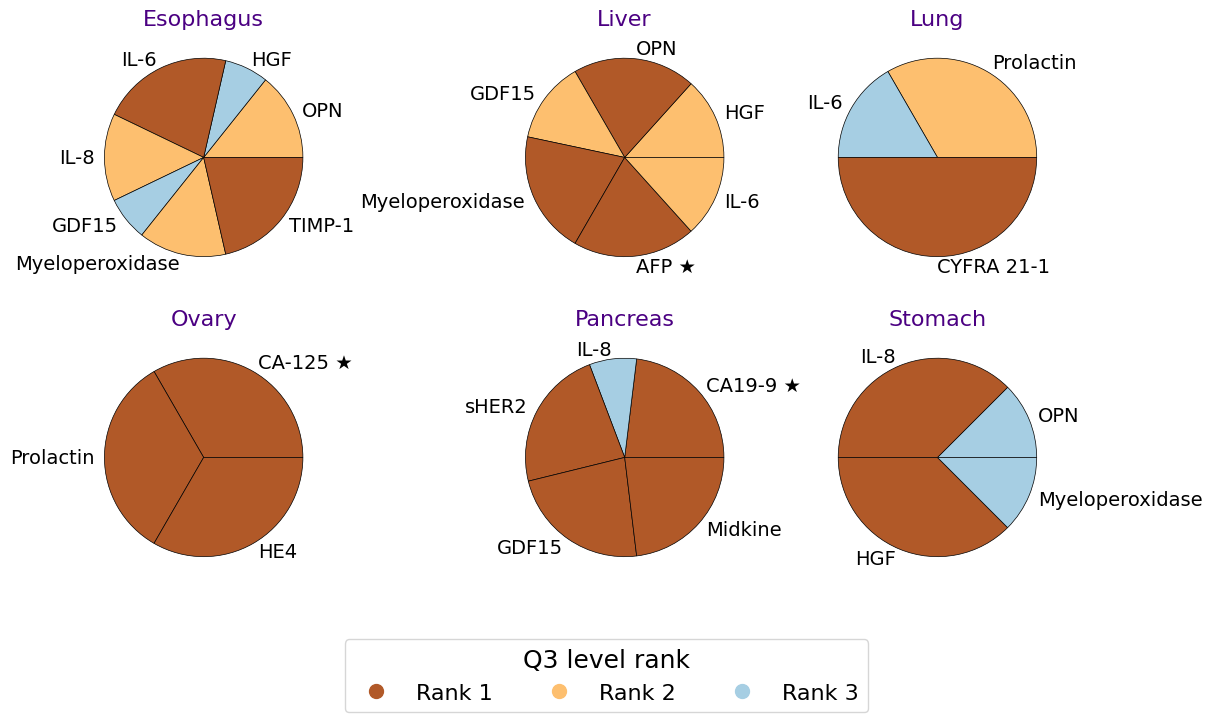

In [81]:
# Create your figure and axes
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs = axs.flatten()

# Get all unique tumor types
tumor_types = higher_side_data_rows_df.Tumor_type.unique()

# Get all unique Weight values and assign a color to each Weight for consistency
unique_ranks = sorted(higher_side_data_rows_df.Q3_rank.unique())
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_ranks)))  # Generate colors
weight_color_map = dict(zip(unique_ranks, colors))  # Map Weight values to colors
rank_color_map = dict(zip(unique_ranks, colors[::-1]))

for i, tumor_type in enumerate(tumor_types):
    tumor_type_filtered_df = higher_side_data_rows_df[
        higher_side_data_rows_df['Tumor_type'] == tumor_type
    ].reset_index(drop=True)
    ax = axs[i]
    
    # Extract weights and assign colors based on the weight->color map
    weights = tumor_type_filtered_df.Weight
    pie_colors = [weight_color_map[w] for w in weights]

    # Plot the pie chart
    ax.pie(weights, 
           labels=tumor_type_filtered_df.Biomarker, 
           colors=pie_colors, 
           wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
           textprops = {'fontsize':14})
    ax.set_title(tumor_type, fontsize=16, fontdict={'color':'indigo'})

# Create a shared legend for unique Weight values
legend_elements = [
    plt.Line2D(
        [0], [0], marker='o', color=rank_color_map[r], linestyle='', markersize=10, label=f"Rank {r}"
    )
    for r in unique_ranks
]

# Add the legend to the figure
fig.legend(
    handles=legend_elements, 
    title="Q3 level rank",
    title_fontsize=18, 
    fontsize=16,
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=3
)

# fig.suptitle("Q3 ranks of the biomarkers (tumor types with the top 3 Q3 levels are considered)\n")

fig.savefig("FIG4.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

#### 6.2.3. Yuen-Welch's test

In [82]:
from stats_tests import heatmap_shared_nature

In [83]:
heatmap_shared_natures = []
cancers_selected_biomarkers = [esophagus_selected_biomarkers, liver_selected_biomarkers, lung_selected_biomarkers, ovary_selected_biomarkers, pancreas_selected_biomarkers, stomach_selected_biomarkers]
cancers_indices = [2, 3, 4, 6, 7, 8]
for i in range(0,6):
    cancer_heatmap_shared_nature = heatmap_shared_nature(categories = categories,dfs = dfs,cancer_category_index = cancers_indices[i],cancer_selected_biomarkers = cancers_selected_biomarkers[i],p_threshold = 0.05)
    heatmap_shared_natures.append(cancer_heatmap_shared_nature)

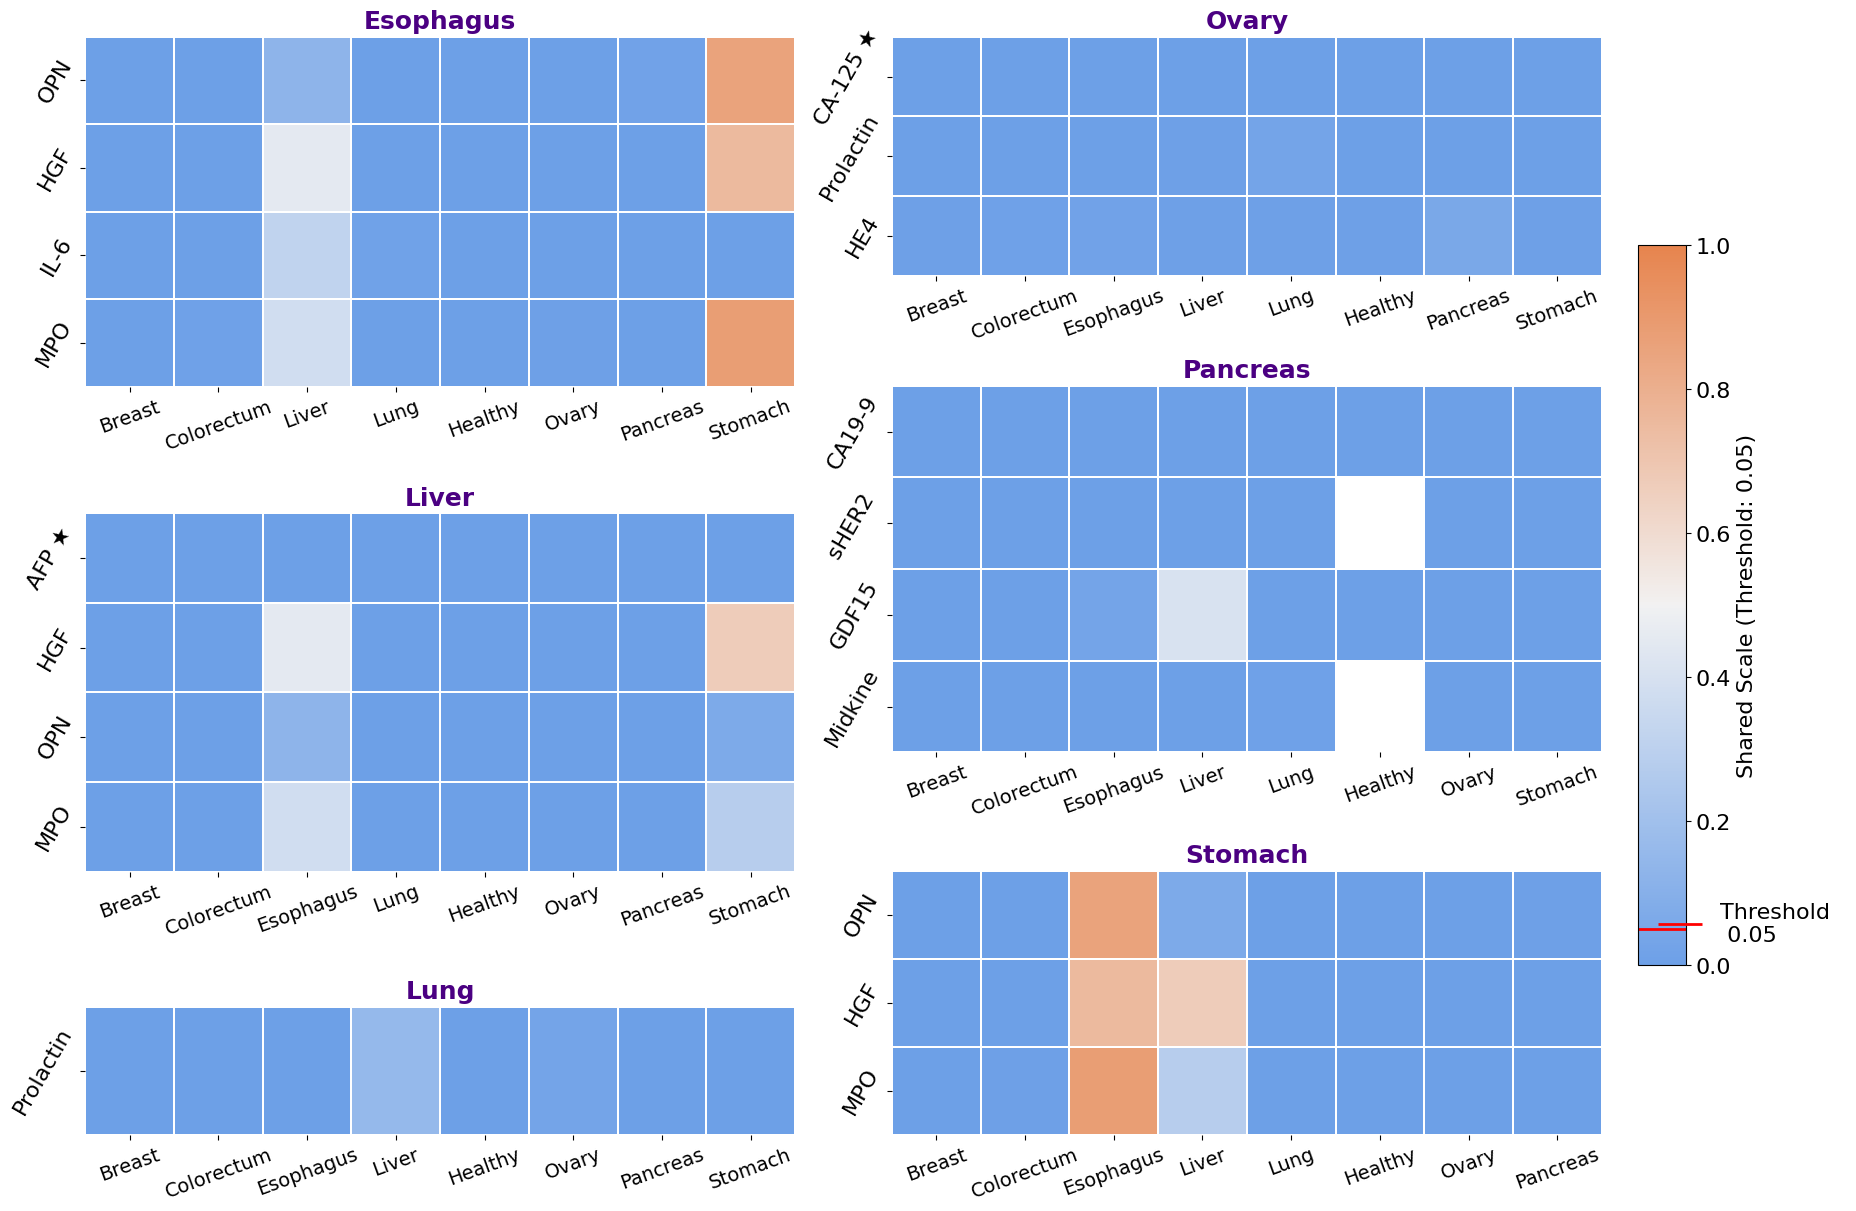

In [84]:
# 4, 4, 1, 3, 4, 3
# heatmap_shared_natures[5]

# Define threshold and colormap bounds
vmin = 0  # Minimum value
vmax = 1  # Maximum value
threshold = 0.05

# Enhanced colormap to emphasize threshold
cmap = sns.diverging_palette(250, 30, l=65, as_cmap=True)  # Custom continuous colormap

# Create figure with flexible layout
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = GridSpec(10, 2, figure=fig)

# Define subplots
ax1 = fig.add_subplot(gs[:4, 0])  # First col, first subplot
ax2 = fig.add_subplot(gs[4:8, 0])  # First col, second subplot
ax3 = fig.add_subplot(gs[8:, 0])  # First col, third subplot
ax4 = fig.add_subplot(gs[:3, 1])  # Second col, first subplot
ax5 = fig.add_subplot(gs[3:7, 1])  # Second col, second subplot
ax6 = fig.add_subplot(gs[7:, 1])  # Second col, third subplot

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

# Plot heatmaps
for ax, df in zip(axs, heatmap_shared_natures):
    df.rename(index={'AFP':'AFP ★', 'CA19-9 ':'CA19-9 ★', 'CA-125':'CA-125 ★', 'sHER2/sEGFR2/sErbB2': 'sHER2 ', 'Myeloperoxidase':'MPO'}, inplace=True)
    df.rename(columns={'Normal':'Healthy'}, inplace=True)
    sns.heatmap(
        df, 
        # annot=True, # For including actual p-values in each cell 
        annot=False, # For not having actual p-values in each cell
        ax=ax, 
        vmin=vmin, 
        vmax=vmax, 
        cmap=cmap, 
        linewidths=0.1,
        cbar=False  # Disable individual colorbars
    )
    ax.set_title(df.name, fontsize=18, fontdict={'fontweight':'heavy', 'color':'indigo'})
    ax.tick_params(axis='x', labelsize=14, labelrotation=20)
    ax.tick_params(axis='y', labelsize=16, labelrotation=60)

# Add shared colorbar
cbar_ax = fig.add_axes([1.02, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)

# Customize the colorbar to mark the threshold
cbar.set_label("Shared Scale (Threshold: 0.05)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Annotate the color legend to emphasize regions below/above the threshold
cbar.ax.hlines(y=threshold, xmin=0, xmax=1, colors="red", lw=2, label=f"Threshold \n {threshold}")
cbar.ax.legend(loc="lower left", frameon=False, fontsize=16)

# fig.suptitle("Shared nature of biomarkers indicated by p-values (threshold = 0.05)\n", fontsize=20)

fig.savefig("FIG5.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

In [85]:
len(rf_important_biomarkers)

19

In [86]:
higher_side_data_rows_df.Biomarker.unique().__len__()

15

In [87]:
important_biomarkers_normal_stomach.Biomarker.unique()

array(['OPN', 'IL-8', 'IL-6', 'GDF15', 'HGF', 'sEGFR', 'Myeloperoxidase',
       'CYFRA 21-1'], dtype=object)

In [88]:
collection = []
for sample_list in cancers_selected_biomarkers:
    collection = collection + sample_list
    
print(len(set(collection)))

15


In [89]:
cancer_shared_nature_of_biomarkers_list = [esophagus_shared_nature_of_biomarkers, liver_shared_nature_of_biomarkers, lung_shared_nature_of_biomarkers, ovary_shared_nature_of_biomarkers, pancreas_shared_nature_of_biomarkers, stomach_shared_nature_of_biomarkers]
reported_biomarkers = []
for cancer_shared_nature_of_biomarkers in cancer_shared_nature_of_biomarkers_list: 
    reported_biomarkers = reported_biomarkers + [biomarkers[i] for i, _ in cancer_shared_nature_of_biomarkers]
    
len(set(reported_biomarkers))

12

## 6.3. Heatmap of the selected Biomarkers

In [90]:
random_forest_biomarkers = list(cv_boxplot_df.Biomarker.unique())
removed_biomarkers =['TGFa', 'IL-8', 'CYFRA 21-1', 'sFas', 'sEGFR', 'NSE', 'TIMP-1']
finalized_biomarkers = [biomarker for biomarker in random_forest_biomarkers if biomarker not in removed_biomarkers]
finalized_biomarkers

['IL-6',
 'Prolactin',
 'OPN',
 'HE4',
 'HGF',
 'GDF15',
 'Myeloperoxidase',
 'AFP ★',
 'CA-125 ★',
 'CA19-9 ★',
 'sHER2',
 'Midkine']

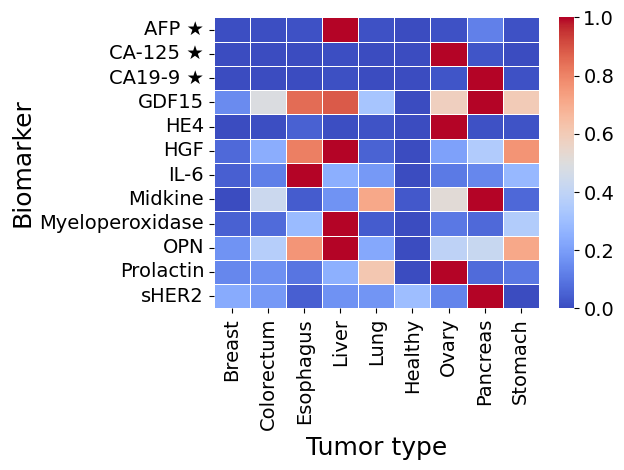

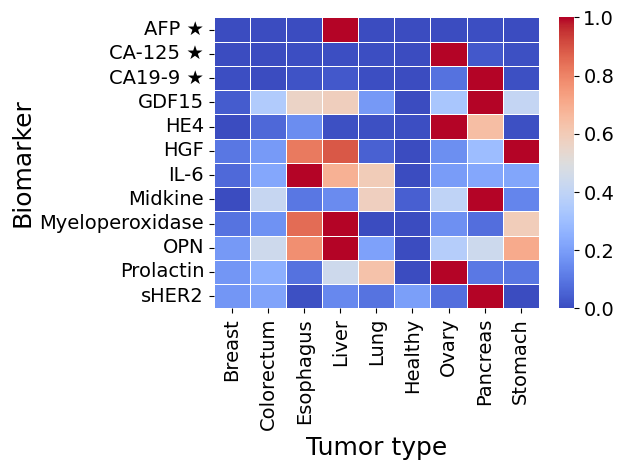

In [91]:
df = cv_boxplot_df[cv_boxplot_df['Biomarker'].isin(finalized_biomarkers)]

# Pivot the data for Q2 and Q3 separately
df_q2 = df[df["Quartile"] == "Q2"].pivot(index="Biomarker", columns="Tumor_type", values="Level")
df_q3 = df[df["Quartile"] == "Q3"].pivot(index="Biomarker", columns="Tumor_type", values="Level")

# Min-max normalization within each biomarker
df_q2_norm = df_q2.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
df_q3_norm = df_q3.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

df_q2_norm.rename(columns={'Normal':'Healthy'}, inplace=True)
df_q3_norm.rename(columns={'Normal':'Healthy'}, inplace=True)
# # Set up the figure
# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # Create the heatmaps
# sns.heatmap(df_q2_norm, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[0])
# axes[0].set_title("Normalized Q2 (Median) Biomarker Levels")

# sns.heatmap(df_q3_norm, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[1])
# axes[1].set_title("Normalized Q3 (Third Quartile) Biomarker Levels")

# Adjust layout and show the plot

# Create the heatmaps
ax1 = sns.heatmap(df_q2_norm,
                 cmap="coolwarm",
                 annot=False,
                 linewidths=0.5)
plt.xlabel("Tumor type", fontsize=18)
plt.ylabel("Biomarker", fontsize=18)
plt.tick_params(axis='x', labelsize=14, labelrotation=90)
plt.tick_params(axis='y', labelsize=14)
# Customize the colorbar fontsize
colorbar1 = ax1.collections[0].colorbar  # Access the colorbar
colorbar1.ax.tick_params(labelsize=14)  # Set tick label size
plt.tight_layout()
plt.savefig("q2_heatmap.pdf", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

ax2 = sns.heatmap(df_q3_norm, 
                 cmap="coolwarm", 
                 annot=False, 
                 linewidths=0.5)
plt.xlabel("Tumor type", fontsize=18)
plt.ylabel("Biomarker", fontsize=18)
plt.tick_params(axis='x', labelsize=14, labelrotation=90)
plt.tick_params(axis='y', labelsize=14)
# Customize the colorbar fontsize
colorbar2 = ax2.collections[0].colorbar  # Access the colorbar
colorbar2.ax.tick_params(labelsize=14)  # Set tick label size
plt.tight_layout()
plt.savefig("q3_heatmap.pdf", dpi=600, bbox_inches='tight', format='pdf')
plt.show()


# 7. Limitations

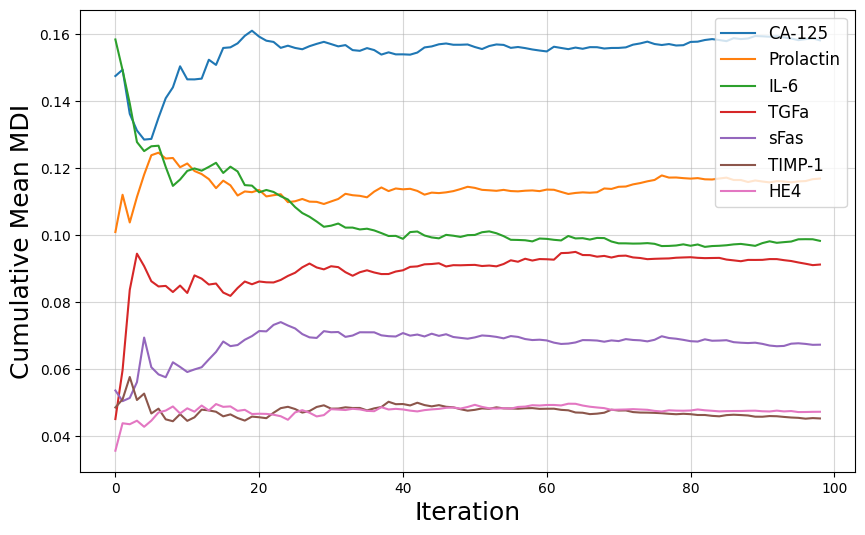

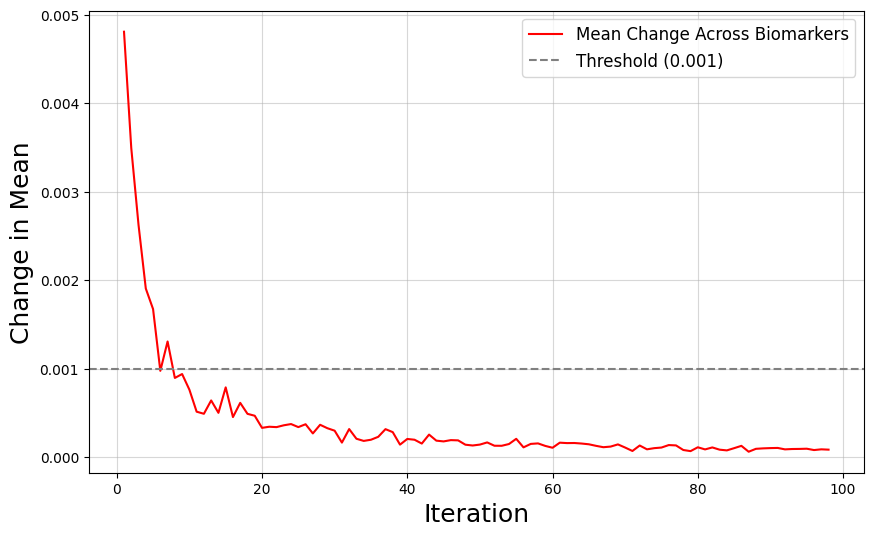

In [92]:
# Load the CSV file, skipping the first row
df = pd.read_csv("feature_importance_list_Normal_Ovary.csv", skiprows=1)

# Convert columns to numeric (in case they are read as strings)
df = df.apply(pd.to_numeric)

# Compute cumulative mean for each biomarker (column-wise)
cumulative_mean = df.expanding().mean()

# Plot convergence for a subset of biomarkers
plt.figure(figsize=(10, 6))
biomarker_indices = [3, 29, 18, 35, 31, 37, 16]
# Plot only the specified biomarkers
for index in biomarker_indices:
    col = df.columns[index]  # Get the column name corresponding to the index
    plt.plot(cumulative_mean.index, cumulative_mean[col], label=f"{biomarkers[index]}")


plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cumulative Mean MDI", fontsize=18)
# plt.title("Convergence of MDI Scores Over Iterations")
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.savefig("normal_ovary_convergence_of_MDI_scores.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()

# Compute change in mean between successive iterations
delta_mean = cumulative_mean.diff().abs().mean(axis=1)

# Plot the rate of change
plt.figure(figsize=(10, 6))
plt.plot(delta_mean, color="red", label="Mean Change Across Biomarkers")
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Change in Mean", fontsize=18)
# plt.title("Stability of Cumulative Mean MDI Scores")
plt.axhline(y=0.001, color="gray", linestyle="--", label="Threshold (0.001)")
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.savefig("normal_ovary_stability_of_cumulative_mean_MDI_scores.pDF", dpi=600, bbox_inches='tight', format='pdf')
plt.show()